In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import networkx as nx
from skimage.io import imread

/Users/mingyuzhu/opt/anaconda3/envs/comp_graph_theory/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#create triangle of a given side length that is positioned upright
def create_triangle(min_len,max_len):
    side_length = np.random.random() * (max_len - min_len) + min_len
    base_coor = (0, 0)
    c = np.tan(np.pi / 6) * (side_length / 2)
    A = (base_coor[0], base_coor[1] + np.sqrt(3) / 2 * side_length - c)
    B = (base_coor[0] -side_length / 2, base_coor[1]  -c)
    C = (base_coor[0] + side_length / 2, base_coor[1]  -c)
    return np.array([A, B, C])

In [3]:
# Help determine if the vertex of the new triangle already exists in the graph,
# if exists, return the position symmetric in respect to the line connected by
# node1 and node2
def triangle_helper(node1,node2,vert_locs):
    node1 = np.array(node1)
    node2 = np.array(node2)

    #Find the center of the edge
    center = np.array([(node1[0] + node2[0]) / 2, (node1[1] + node2[1])/2])

    #find the direction of the new node
    vec = node1 - node2
    len_vec = (vec[0]**2 + vec[1]**2)**(0.5)
    dir = np.dot(np.array([[0,-1],[1,0]]), (vec / len_vec))

    #Find the two candidate points
    pt1 = center + dir * np.sqrt(3) / 2 * len_vec
    pt2 = center + dir * np.sqrt(3) / 2 * len_vec * (-1)

    min_dis_1 = 10000
    closest_neighbor_1 = None
    min_dis_2 = 10000
    closest_neighbor_2 = None

    #check if pt1 is already in vert_locs
    for i in range(len(vert_locs)):
        vert = vert_locs[i]
        dis = np.sqrt((vert[0] - pt1[0])**2 + (vert[1] - pt1[1])**2)
        if (dis < min_dis_1):
            min_dis_1 = dis
            closest_neighbor_1 = i

    for i in range(len(vert_locs)):
        vert = vert_locs[i]
        dis = np.sqrt((vert[0] - pt2[0])**2 + (vert[1] - pt2[1])**2)
        if (dis < min_dis_2):
            min_dis_2 = dis
            closest_neighbor_2 = i

    #closure
    if (min_dis_1 < len_vec / 100 and min_dis_2 < len_vec/100):
        return True, [pt1,pt2,closest_neighbor_1,closest_neighbor_2]

    else:
        if (min_dis_1 <= len_vec / 100):
            return False, [pt2]
        else:
            return False, [pt1]

# Take in two nodes, return the center of the line that connects these two nodes
def edge_sampler(node1,node2):
    node1 = np.array(node1)
    node2 = np.array(node2)
    center = np.array([(node1[0] + node2[0]) / 2, (node1[1] + node2[1])/2])
    return int(center[0]),int(center[1])

In [5]:
# The following function takes a binary image representation and a filter size. It applies a filter to the binary image to determine where the main object is and return a starting point for drawing the initial triangle
def get_image_start_pts(img, filter_size):
    my_filter = np.random.random([filter_size, filter_size])
    convolved = convolve(img, my_filter)
    max_idx = np.unravel_index(np.argmax(convolved),convolved.shape)
    return max_idx

In [6]:
# Checks if the coordinate (x,y) is within the highlighted part of the image
def point_valid(x,y,img):
    if (x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[1]):
        return img[int(x), int(y)] == 1
    else:
        return False

In [33]:
# This function is similar to create_multi_triangle_rec, but it generates a mesh of an image.
# It takes in two additional arguments -- boundary_edges and img, and adds only one triangle every time.
def create_multi_triangle_img_rec(vertice_locations, boundary_edges, edges, outer_edges, triangles, img):
    case_1_on = True
    case_2_on = True
    case_3_on = True

    #Sometimes there are remove errors, we catch them but want to count how many
    num_remove_errors = 0

    #Pick a random edge, and assign the original vertices.
    rand_idx = np.random.randint(0,len(outer_edges))
    orig_ver1 = list(outer_edges[rand_idx])[0]
    orig_ver2 = list(outer_edges[rand_idx])[1]
    closure, new_vertexs = triangle_helper(vertice_locations[orig_ver1],vertice_locations[orig_ver2], vertice_locations)


    if closure == False:
         #operation 0, add one node, two edges and remove two outer edges
        new_vertex = new_vertexs[0]

        if point_valid(new_vertex[0],new_vertex[1],img):
            #Create new vertex and edges
            vertice_locations.append((new_vertex[0],new_vertex[1]))
            new_edge1 = {orig_ver1, len(vertice_locations) - 1}
            new_edge2 = {orig_ver2, len(vertice_locations) - 1}

            #Add new edges to existing list
            edges.append(new_edge1)
            edges.append(new_edge2)

            triangles.append({orig_ver1, orig_ver2, len(vertice_locations) - 1})

            #Remove old outer edges and add new ones
            outer_edges.remove({orig_ver1, orig_ver2})
            outer_edges.append(new_edge1)
            outer_edges.append(new_edge2)


        else:
            outer_edges.remove({orig_ver1, orig_ver2})
            boundary_edges.append({orig_ver1, orig_ver2})


    else:
        clo_nei1 = new_vertexs[2]
        clo_nei2 = new_vertexs[3]

        #Logic Processing to determine which operation to perform
        c1o1 = {clo_nei1, orig_ver1} not in edges
        c1o2 = {clo_nei1, orig_ver2} not in edges
        c2o1 = {clo_nei2, orig_ver1} not in edges
        c2o2 = {clo_nei2, orig_ver2} not in edges

        #operation 1, add no edge or node and remove three edges from outer edge
        if ((not c1o1) and (not c1o2) ) and ((not c2o1) and (not c2o2)):
            if (case_1_on):
                if {orig_ver1, orig_ver2, clo_nei1} in triangles:
                    triangles.append({clo_nei2, orig_ver1, orig_ver2})

                    #Remove the three outer edges that form this triangle
                    try:
                        outer_edges.remove({orig_ver1, orig_ver2})
                    except:
                        num_remove_errors += 1

                    try:
                        outer_edges.remove({clo_nei2, orig_ver1})
                    except:
                        num_remove_errors += 1

                    try:
                        outer_edges.remove({clo_nei2, orig_ver2})
                    except:
                        num_remove_errors += 1

                else:
                    triangles.append({clo_nei1, orig_ver1, orig_ver2})

                    #Remove the three outer edges that form this triangle
                    try:
                        outer_edges.remove({orig_ver1, orig_ver2})
                    except:
                        num_remove_errors += 1
                    try:
                        outer_edges.remove({clo_nei1, orig_ver1})
                    except:
                        num_remove_errors += 1

                    try:
                        outer_edges.remove({clo_nei1, orig_ver2})
                    except:
                        num_remove_errors += 1
            else:
                boundary_edges.append(outer_edges[rand_idx])
                outer_edges.remove(outer_edges[rand_idx])


        #operation 2, add two edges and remove one edge from outer edces.
        elif (c1o1 and c1o2) or (c2o1 and c2o2):
            if (case_2_on):
                #the following if statement decides which side to add
                if (c1o1 and c1o2):
                    #Create new edge
                    new_edge1 = {clo_nei1, orig_ver1}
                    new_edge2 = {clo_nei1, orig_ver2}

                    #Add to existing list of edges
                    edges.append(new_edge1)
                    edges.append(new_edge2)

                    center_1 = edge_sampler(vertice_locations[clo_nei1],vertice_locations[orig_ver1])
                    center_2 = edge_sampler(vertice_locations[clo_nei1],vertice_locations[orig_ver2])

                    triangles.append({clo_nei1, orig_ver1, orig_ver2})

                    #Remove old outer edges and add new ones
                    outer_edges.remove(outer_edges[rand_idx])

                    if point_valid(center_1[0],center_1[1],img):
                        outer_edges.append(new_edge1)
                    else:
                        boundary_edges.append(new_edge1)

                    if point_valid(center_2[0],center_2[1],img):
                        outer_edges.append(new_edge2)
                    else:
                        boundary_edges.append(new_edge2)

                else:
                    #Create new edge
                    new_edge1 = {clo_nei2, orig_ver1}
                    new_edge2 = {clo_nei2, orig_ver2}
                    edges.append(new_edge1)
                    edges.append(new_edge2)

                    #Add to existing list of edges
                    center_1 = edge_sampler(vertice_locations[clo_nei2],vertice_locations[orig_ver1])
                    center_2 = edge_sampler(vertice_locations[clo_nei2],vertice_locations[orig_ver2])

                    triangles.append({clo_nei2, orig_ver1, orig_ver2})

                    #Remove old outer edges and add new ones
                    outer_edges.remove(outer_edges[rand_idx])

                    if point_valid(center_1[0],center_1[1],img):
                        outer_edges.append(new_edge1)
                    else:
                        boundary_edges.append(new_edge1)

                    if point_valid(center_2[0],center_2[1],img):
                        outer_edges.append(new_edge2)
                    else:
                        boundary_edges.append(new_edge2)
            else:
                boundary_edges.append(outer_edges[rand_idx])
                outer_edges.remove(outer_edges[rand_idx])


        #rnm case 3
        else:
            if (case_3_on):
                #The following if statements determine which side to add the edge to, there are a total of four scenarios.
                #subcase 0
                if {orig_ver1, clo_nei1} not in edges:
                    #Create new edge
                    new_edge = {orig_ver1, clo_nei1}

                    center = edge_sampler(vertice_locations[orig_ver1],vertice_locations[clo_nei1])

                    #Add to existing list of edges

                    edges.append(new_edge)

                    triangles.append({orig_ver1, orig_ver2, clo_nei1})

                    #Remove old outer edges and add new ones
                    outer_edges.remove(outer_edges[rand_idx])

                    try:
                        outer_edges.remove({clo_nei1, orig_ver2})
                    except:
                        num_remove_errors += 1

                    if point_valid(center[0],center[1],img):
                        outer_edges.append(new_edge)
                    else:
                        boundary_edges.append(new_edge)


                elif {orig_ver1, clo_nei2} not in edges:
                    #Create new edge
                    new_edge = {orig_ver1, clo_nei2}

                    center = edge_sampler(vertice_locations[orig_ver1],vertice_locations[clo_nei2])

                    #Add to existing list of edges

                    edges.append(new_edge)

                    triangles.append({orig_ver1, orig_ver2, clo_nei2})

                    #Remove old outer edges and add new ones
                    outer_edges.remove(outer_edges[rand_idx])

                    try:
                        outer_edges.remove({clo_nei2, orig_ver2})
                    except:
                        num_remove_errors += 1

                    if point_valid(center[0],center[1],img):
                        outer_edges.append(new_edge)
                    else:
                        boundary_edges.append(new_edge)

                elif {orig_ver2, clo_nei1} not in edges:
                    #Create new edge
                    new_edge = {orig_ver2, clo_nei1}

                    center = edge_sampler(vertice_locations[orig_ver2],vertice_locations[clo_nei1])

                    #Add to existing list of edges

                    edges.append(new_edge)

                    triangles.append({orig_ver1, orig_ver2, clo_nei1})

                    #Remove old outer edges and add new ones
                    outer_edges.remove(outer_edges[rand_idx])

                    try:
                        outer_edges.remove({clo_nei1, orig_ver1})
                    except:
                        num_remove_errors += 1


                    if point_valid(center[0],center[1],img):
                        outer_edges.append(new_edge)
                    else:
                        boundary_edges.append(new_edge)
                else:
                    #Create new edge
                    new_edge = {orig_ver2, clo_nei2}

                    center = edge_sampler(vertice_locations[orig_ver2],vertice_locations[clo_nei2])

                    #Add to existing list of edges
                    edges.append(new_edge)
                    triangles.append({orig_ver1, orig_ver2, clo_nei2})


                    #Remove old outer edges and add new ones
                    outer_edges.remove(outer_edges[rand_idx])
                    try:
                        outer_edges.remove({clo_nei2, orig_ver1})
                    except:
                        num_remove_errors += 1


                    if point_valid(center[0],center[1],img):
                        outer_edges.append(new_edge)
                    else:
                        boundary_edges.append(new_edge)

            else:
                boundary_edges.append(outer_edges[rand_idx])
                outer_edges.remove(outer_edges[rand_idx])

    return vertice_locations, boundary_edges, edges, outer_edges, triangles, img

In [45]:
# Given a list of edges, this function initializes a Networkx graph then adds edges to the graph
def mesh_to_graph(edges):
    G = nx.Graph()
    for edge in edges:
        e = list(edge)
        G.add_edge(e[0],e[1])

    lap_mat = nx.laplacian_matrix(G).toarray()
    evals, U = np.linalg.eigh(lap_mat)
    return evals,U,G

# Given a list of triangles, this function converts all the triangles to nodes instead of triangle vertices to nodes.
def mesh_to_graph2(triangles):
    G = nx.Graph()
    for i in range(len(triangles)):
        curr_triangle = triangles[i]
        num_nei = 0
        for j in range(len(triangles)):
            #A node can have at most 6 edges
            if (i == j or num_nei == 6):
                pass
            else:
                neighbor_triangle = triangles[j]
                union = curr_triangle.union(neighbor_triangle)
                #If they are connected by an edge
                if (len(union) == 4):
                    if (not G.has_edge(i,j)) and (not G.has_edge(j,i)):
                        G.add_edge(i,j, weight=1)
                    num_nei += 1
                #If they are connected by a node
                elif len(union) == 5:
                    if (not G.has_edge(i,j)) and (not G.has_edge(j,i)):
                        G.add_edge(i,j, weight=0.1)
                    num_nei += 1

    #
    lap_mat = nx.laplacian_matrix(G).toarray()
    evals, U = np.linalg.eigh(lap_mat)
    return evals,U,G
    #return G

In [46]:
# Heat kernel signature at t
def hkt(t,evals,U):
    exp = np.exp(t*evals)
    lamb = np.diag(exp)
    return U.dot(lamb).dot(U.T)

# Calculate a bunch of heat kernel signatures given ts
def hks(ts,evals,U):
    toret = np.empty([ts.shape[0]])
    for i in range(ts.shape[0]):
        t = ts[i]
        kernel = hkt(t,evals,U)
        diagonal = np.diag(kernel)
        toret[i] = np.mean(diagonal)
    return toret

In [81]:
# Read in the image
img = imread('circle 2.png')[:,:,0]
# Convert the original image to a binary image
img = np.where(img > 200,1,0)
# Retrieve the starting position for the first triangle
start_x,start_y = get_image_start_pts(img,40)




sigs_as = []
sigs_bs = []

# The following loop runs 40 times. At each iteration, it will generate 10 different ts as well as two randomly generated triangular mesh graphs given a fixed shape (a circle in this case.) Then it will calculate the heat kernel signature for the random triangular mesh at each t.
for n in range(40):
    print(n)
    source = create_triangle(10,10)
    source = source + np.array([(np.random.random()-0.5)*200 + 172,172 + (np.random.random()-0.5)*200])

    #Generate random ts to remove artifacts
    ts = np.random.random(10)

    vertice_locations = [(source[0,0],source[0,1]),(source[1,0],source[1,1]),(source[2,0],source[2,1])]
    edges = [{0, 1}, {0, 2}, {1, 2}]
    outer_edges = edges.copy()
    boundary_edges = []
    triangles = [{0, 1, 2}]

    i = 0
    sigs_a = []

    while i <= 5000 and len(outer_edges) > 0:
        vertice_locations,boundary_edges,edges,outer_edges,triangles,img = create_multi_triangle_img_rec(vertice_locations,boundary_edges,edges,outer_edges,triangles,img)

        if (i % 100 == 0 and i != 0):
            evals, U, _ = mesh_to_graph(edges)
            sigs_a.append(hks(ts,evals,U))

        i += 1

    vertice_locations = [(source[0,0],source[0,1]),(source[1,0],source[1,1]),(source[2,0],source[2,1])]
    edges = [{0, 1}, {0, 2}, {1, 2}]
    outer_edges = edges.copy()
    boundary_edges = []
    triangles = [{0, 1, 2}]

    i = 0
    sigs_b = []

    while i <= 5000 and len(outer_edges) > 0:
        vertice_locations,boundary_edges,edges,outer_edges,triangles,img = create_multi_triangle_img_rec(vertice_locations,boundary_edges,edges,outer_edges,triangles,img)

        if (i % 100 == 0 and i != 0):
            evals, U, _ = mesh_to_graph(edges)
            sigs_b.append(hks(ts,evals,U))

        i += 1

    sigs_as.append(sigs_a)
    sigs_bs.append(sigs_b)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [99]:
da = np.array(sigs_as)
db = np.array(sigs_bs)

# Calculate the difference between every heat kernel signature
diff = da - db
diff.shape


(40, 22, 10)

In [126]:
# Calculate the mean difference
diff_sqr = diff **2
diff_sum = np.sum(diff_sqr,axis = 2)
diff_dis = np.sqrt(diff_sum)
diff_dis_mean = np.mean(diff_dis,axis = 0)
diff_dis_mean.shape

(22,)

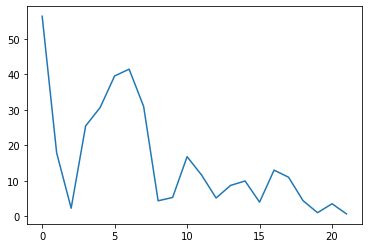

In [136]:
plt.plot(diff_dis[18]) #2,6,35,26,30,18

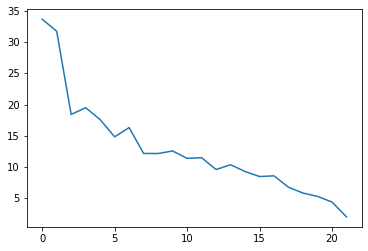

In [138]:
plt.plot(diff_dis_mean)